In [1]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load libraries
import os, time, json, re, copy
import itertools, argparse, pickle, random

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import nltk

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

%reload_ext autoreload
%autoreload 2

## Download data

In [0]:
path = '/content'
# path = '/content/data'
# if not os.path.exists(path): os.mkdir(path)
# os.chdir(path)

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [5]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -f train.csv

 98% 268M/273M [00:07<00:00, 32.3MB/s]
100% 273M/273M [00:07<00:00, 39.0MB/s]


In [6]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -f test.csv

 75% 9.00M/12.0M [00:00<00:00, 6.30MB/s]
100% 12.0M/12.0M [00:00<00:00, 18.8MB/s]


In [7]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [8]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
!rm train.csv.zip test.csv.zip

## Load data

In [4]:
%%time
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))

CPU times: user 13.6 s, sys: 8.11 s, total: 21.7 s
Wall time: 21.7 s


In [11]:
train.shape, test.shape

((1804874, 45), (97320, 2))

In [0]:
# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

aux_columns = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

label_column = 'target'
text_column = 'comment_text'

# Convert target and identity columns to booleans    
def convert_dataframe_to_bool(df):
    def convert_to_bool(df, col_name):
        df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
    bool_df = df.copy()
    for col in [label_column] + identity_columns + aux_columns:
        convert_to_bool(bool_df, col)
    return bool_df

booled = convert_dataframe_to_bool(train)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
id                                     int64
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float

In [6]:
for c in identity_columns:
    train[c][train[c].isna()] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
train[[label_column] + identity_columns + aux_columns].describe()

,target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,2.439631e-02,2.865743e-02,5.748664e-03,2.138429e-02,4.009517e-03,1.110191e-02,7.719921e-03,1.278334e-02,2.712230e-03,4.582099e-03,1.387721e-02,9.311271e-03,8.115273e-02,2.263571e-02,6.605974e-03
std,1.970757e-01,1.347798e-01,1.541778e-01,6.893344e-02,1.279360e-01,5.834757e-02,9.811484e-02,8.083106e-02,1.050397e-01,4.255257e-02,2.286128e-02,6.460419e-02,4.942218e-02,1.760657e-01,7.873156e-02,4.529782e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [51]:
train[[label_column] + aux_columns].mean()

target             0.103017
severe_toxicity    0.004582
obscene            0.013877
threat             0.009311
insult             0.081153
identity_attack    0.022636
sexual_explicit    0.006606
dtype: float64

In [52]:
train[identity_columns].mean()

male                             0.024396
female                           0.028657
homosexual_gay_or_lesbian        0.005749
christian                        0.021384
jewish                           0.004010
muslim                           0.011102
black                            0.007720
white                            0.012783
psychiatric_or_mental_illness    0.002712
dtype: float64

## Some observations between target and attributes

original v.s. booled

In [94]:
# number of examples with identity labeled (Subgroup)
len(train[train[identity_columns].sum(1)>0]), len(booled[booled[identity_columns].sum(1)>0])

(210192, 163810)

In [95]:
# number of examples with identity labeled also marked toxic (Subgroup positive)
len(train[(train[identity_columns].sum(1)>0) & train[label_column]]), len(booled[(booled[identity_columns].sum(1)>0) & booled[label_column]])

(106747, 27222)

In [96]:
# number of examples with identity labeled but marked non-toxic (Subgroup negative)
len(train[(train[identity_columns].sum(1)>0) & (train[label_column]==0)]), len(booled[(booled[identity_columns].sum(1)>0) & (booled[label_column]==0)])

(103445, 136588)

In [97]:
# number of examples with no identity labeled but marked toxic (Background positive)
len(train[(train[identity_columns].sum(1)==0) & train[label_column]]), len(booled[(booled[identity_columns].sum(1)==0) & booled[label_column]])

(433363, 117112)

In [98]:
# number of examples with no identity labeled but marked non-toxic (Background negative)
len(train[(train[identity_columns].sum(1)==0) & (train[label_column]==0)]), len(booled[(booled[identity_columns].sum(1)==0) & (booled[label_column]==0)])

(1161319, 1523952)

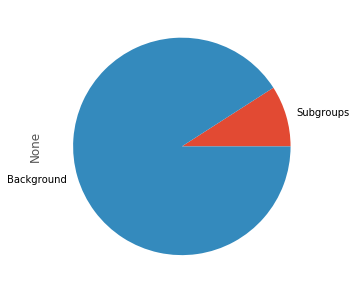

In [43]:
ps = pd.Series([len(booled[booled[identity_columns].sum(1)>0]), len(booled[booled[identity_columns].sum(1)==0])],
                index=['Subgroups', 'Background'])
ps.plot(kind='pie', figsize=(5, 5), use_index=True);

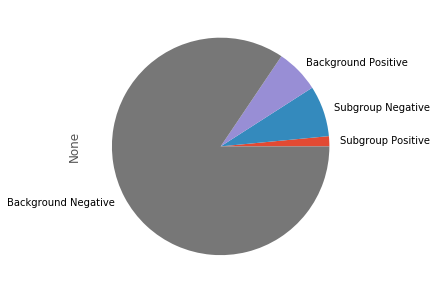

In [44]:
ps = pd.Series([len(booled[(booled[identity_columns].sum(1)>0) & booled[label_column]]), len(booled[(booled[identity_columns].sum(1)>0) & (booled[label_column]==0)]), \
                len(booled[(booled[identity_columns].sum(1)==0) & booled[label_column]]), len(booled[(booled[identity_columns].sum(1)==0) & (booled[label_column]==0)])],
                index=['Subgroup Positive', 'Subgroup Negative', 'Background Positive', 'Background Negative'])
ps.plot(kind='pie', figsize=(5, 5), use_index=True);

Toxic Ratio of those without identities (background) and those with identities (subgroup)

In [61]:
train[label_column][train[identity_columns].sum(axis=1) == 0].mean(), train[label_column][train[identity_columns].sum(axis=1) > 0].mean()

(0.0922544082432606, 0.18467301111887488)

Correlations between target and aux_columns/identities

In [0]:
# corr between target and auxiliary column
[np.corrcoef(booled['target'], booled[col])[0,1] for col in aux_columns]

[0.14937174024344235,
 0.009103117380760339,
 0.24290621229245338,
 0.16079152240067235,
 0.8288890764957709,
 0.27007966990234156]

In [100]:
# corr between target and identity column
[np.corrcoef(booled['target'], booled[col])[0,1] for col in identity_columns]

[0.041205085810161565,
 0.036617343150794755,
 0.05883812613080836,
 0.006079647183600731,
 0.019749042620974756,
 0.05906232589011604,
 0.07870129469102174,
 0.08780748886627944,
 0.025113987973283743]

Association between target and aux columns

In [10]:
# Toxic with aux column positive
[(booled['target'][booled[col]]).mean() for col in aux_columns]

[1.0,
 0.9808393210455066,
 0.9745327102803738,
 0.9776597142696228,
 0.926696495152871,
 0.8740930431071277]

In [15]:
# Non-toxic with aux column negative
[(booled['target'][~booled[col]] == False).mean() for col in aux_columns]

[0.9200376095444469,
 0.9248497859097596,
 0.9221573547396026,
 0.9763416041546451,
 0.9263691595253938,
 0.9220981364168631]

Association between target and identities

In [18]:
# Subgroup positive
[(booled['target'][booled[col]]).mean() for col in identity_columns]

[0.1502787519107994,
 0.13683580078234667,
 0.28380467400200055,
 0.09086411201543676,
 0.16207031760554175,
 0.22760163762734456,
 0.3139386618347762,
 0.28059963320309383,
 0.21067703006749847]

In [21]:
# Subgroup negative
[(booled['target'][booled[col]] == False).mean() for col in identity_columns]

[0.8497212480892006,
 0.8631641992176533,
 0.7161953259979994,
 0.9091358879845632,
 0.8379296823944582,
 0.7723983623726555,
 0.6860613381652239,
 0.7194003667969061,
 0.7893229699325015]

In [20]:
# Background positive
[(booled['target'][~booled[col]]).mean() for col in identity_columns]

[0.07819233238089288,
 0.0782342579983956,
 0.07871944397525583,
 0.07971941414071572,
 0.07961950186482145,
 0.07823056414488068,
 0.07802128858926922,
 0.07714159856882152,
 0.07961399678330652]

In [19]:
# Background negative
[(booled['target'][~booled[col]] == False).mean() for col in identity_columns]

[0.9218076676191072,
 0.9217657420016044,
 0.9212805560247441,
 0.9202805858592843,
 0.9203804981351785,
 0.9217694358551193,
 0.9219787114107307,
 0.9228584014311785,
 0.9203860032166935]

## Clean text and see statistics

In [0]:
# Text cleaning helper function
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
symbols_to_isolate = ''.join(puncts)
isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}


# Text preprocessing
def clean_punc(x):
    x = str(x)
    x = x.translate(isolate_dict)
    return x

def clean_text(raw):
    x = clean_punc(raw.lower())
    return x.strip()

In [23]:
%%time
tqdm.pandas()
train_cln = train['comment_text'].progress_apply(clean_text)
test_cln = test['comment_text'].progress_apply(clean_text)


CPU times: user 42.9 s, sys: 703 ms, total: 43.6 s
Wall time: 43.6 s


Calculate the distribution of sentence lengths

In [0]:
nb_rev_trn, seq_len_trn = range(len(train_cln)), train_cln.apply(lambda s: len(s.split()))
nb_rev_tt, seq_len_tt = range(len(test_cln)), test_cln.apply(lambda s: len(s.split()))

In [32]:
seq_len_trn.describe()

count    1.804874e+06
mean     6.285052e+01
std      5.558764e+01
min      1.000000e+00
25%      2.100000e+01
50%      4.300000e+01
75%      8.700000e+01
max      7.140000e+02
Name: comment_text, dtype: float64

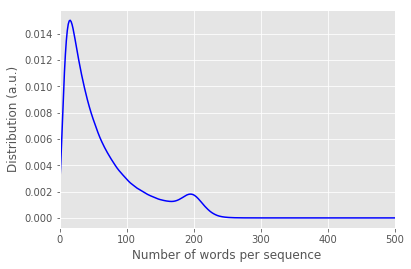

CPU times: user 48.9 s, sys: 553 ms, total: 49.4 s
Wall time: 49.2 s


In [33]:
%%time
seq_len_trn.plot.density(color='blue')
plt.xlim(0, 500)
plt.xlabel('Number of words per sequence')
plt.ylabel('Distribution (a.u.)')
plt.show()

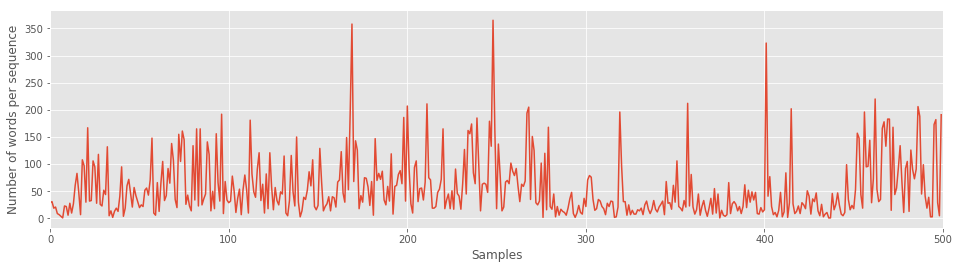

In [45]:
# see the lengths of sequence in a range
plt.figure(figsize=(16,4))
plt.plot(nb_rev_trn[:500], seq_len_trn[:500])
plt.xlim(0, 500)
plt.xlabel('Samples')
plt.ylabel('Number of words per sequence')
plt.show()

In [46]:
seq_len_tt.describe()

count    97320.000000
mean        62.601038
std         55.342074
min          1.000000
25%         21.000000
50%         43.000000
75%         87.000000
max        323.000000
Name: comment_text, dtype: float64

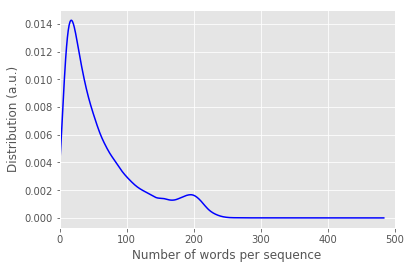

In [47]:
seq_len_tt.plot.density(color='blue')
plt.xlim(0, 500)
plt.xlabel('Number of words per sequence')
plt.ylabel('Distribution (a.u.)')
plt.show()

Observe volume of vocabulary in the corpus

In [0]:
def build_vocab(sentences, verbose=True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable=(not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def most_common_vocab(vocab, k):
    """
    :param vocab: dictionary of words and their count
    :k: former k words to return
    :return: list of k most common words
    """
    sorted_vocab = sorted([(cnt,w) for w,cnt in vocab.items()])[::-1]
    return [(w,cnt) for cnt,w in sorted_vocab][:k]

In [49]:
%%time
# number of words in cleaned train set
word_freq = build_vocab(list(train_cln.apply(lambda x: x.split())))
print(f'number of words in this vocabulary, {len(word_freq)}')


number of words in this vocabulary, 312034
CPU times: user 52.2 s, sys: 5.45 s, total: 57.7 s
Wall time: 57.6 s


In [50]:
%%time
# test set included
word_freq = build_vocab(list(
    pd.concat([train_cln, test_cln], ignore_index=True).apply(lambda x: x.split()) ))
print(f'number of words in this vocabulary, {len(word_freq)}')


number of words in this vocabulary, 320849
CPU times: user 54.1 s, sys: 632 ms, total: 54.8 s
Wall time: 54.8 s


In [0]:
# Tokenize the review sentences as input; 'UNK' means the words not included
vocab_size = 100000
vocab_freq = most_common_vocab(word_freq, vocab_size-1)
idx_to_word = ['PAD'] + [w[0] for w in vocab_freq] + ['UNK']
word_to_idx = {w: i for i, w in enumerate(idx_to_word)}

In [52]:
idx_to_word[:10]

['PAD', '.', 'the', ',', 'to', 'and', 'of', 'a', "'", 'is']

In [53]:
idx_to_word[-10:]

['disalvo',
 'disagee',
 'disaffiliation',
 'disabilites',
 'dirlewanger',
 'dirigible',
 'directorial',
 'directorates',
 'directionality',
 'UNK']

In [54]:
word_freq['disalvo'], word_freq['dirlewanger'], word_freq['directionality']

(4, 4, 4)

## Observe the comment texts

Observe comment texts cleaned to nearly no word

In [62]:
zero_w_id = np.array(list(train_cln[train_cln.apply(lambda s: len(s.split()))==0].index))
len(zero_w_id), zero_w_id[:10]

(0, array([], dtype=float64))

In [63]:
one_w_id = np.array(list(train_cln[train_cln.apply(lambda s: len(s.split()))==1].index))
len(one_w_id), one_w_id[:10]

(3123, array([   7,  375,  436,  437,  860,  956, 1023, 1075, 1396, 3669]))

In [59]:
print(train['comment_text'].loc[7])

FFFFUUUUUUUUUUUUUUU


In [64]:
print(train['comment_text'].loc[3669])

SNITCH


In [65]:
two_w_id = np.array(list(train_cln[train_cln.apply(lambda s: len(s.split()))==2].index))
len(two_w_id), two_w_id

(9410, array([     35,     276,     294, ..., 1804654, 1804676, 1804833]))

In [0]:
print(train['comment_text'].loc[276])

:(


In [0]:
print(train['comment_text'].loc[1804654])

Exactly.


### Observe some comment texts

Subgroup positive

In [80]:
train[[label_column]+identity_columns][(booled[identity_columns].sum(1)>0) & booled[label_column]][:15]

,target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
31,0.912500,0.0,0.00,0.0,1.0,0.0,1.0,0.0,0.00,0.0
34,0.830769,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0
189,0.500000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.80,0.0
609,0.600000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,1.0
648,0.545455,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.7
727,0.545455,0.8,0.10,0.1,0.0,0.0,0.0,0.0,0.00,0.0
842,0.600000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,1.0
956,0.878788,0.0,0.00,0.0,0.0,0.0,0.0,0.6,0.00,0.0
1569,0.500000,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.75,0.0
1681,0.800000,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [75]:
for i,s in enumerate(train['comment_text'][(booled[identity_columns].sum(1)>0) & booled[label_column]][:15]):
    print(f'{i+1}. ' + s)

1. Yet call out all Muslims for the acts of a few will get you pilloried.   So why is it okay to smear an entire religion over these few idiots?  Or is this because it's okay to bash Christian sects?
2. This bitch is nuts. Who would read a book by a woman.
3. “Will Whiteness History Month make all white people hate themselves? Will white students cry themselves to sleep for the rest of their lives?”

Hahahahahaha. This makes me very happy. The whole idea sounds a little bit ridiculous but it’s bound to spark some real political hostility! Hoorah for PCC.
4. This is what a serious mental illness looks like, a sociopathic paranoic  criminal hysteria, armed and very dangerous....
5. This is what a serious mental illness looks like, these paramilitaries/militias/”sovereign citizens”, a sociopathic paranoic delusional criminal hysteria, contagious to a degree, armed and very dangerous.
6. Love it!  Alas, though, there are no fun non-derogatory nouns for the male equivalent of tomboy.  My so

Subgroup negative

In [79]:
train[[label_column]+identity_columns][(booled[identity_columns].sum(1)>0) & ~booled[label_column]][:15]

,target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
11,0.440000,0.600000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
68,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,1.0
185,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.00,0.0,0.0
191,0.300000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.00,1.0,0.0
197,0.000000,0.000000,0.833333,0.0,0.0,0.0,0.0,0.00,0.0,0.0
200,0.200000,0.000000,0.600000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
216,0.200000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
221,0.000000,0.000000,0.800000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
250,0.000000,0.833333,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
275,0.300000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.75,1.0,0.0


In [81]:
for i,s in enumerate(train['comment_text'][(booled[identity_columns].sum(1)>0) & ~booled[label_column]][:15]):
    print(f'{i+1}. ' + s)

1. This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever heard it.
2. I think you left out one very important organization who help the mentally ill over 18. NAMI Multnomah. They help people with mental distress find within or without NAMI to find them the services that can be most beneficial to them.  I am a volunteer for NAMI Multnomah in their Connection program. It is a walk-in group to people 18 and up. No matter the diagnosis we welcome them and help them learn new coping skills and develop tools to further  help them learn to cope from week to week. We have groups all over Multnomah County. By going  to http://nami.multnomah.org/. You will with out much difficulty find the list of Connection Groups and their times and locations.
3. Should they have to? 

Christians, whether as a whole, or split by denomination would never submit to such a requirement. If a religion, any religion, had to offer an apology, or disclaimer, every time a crimina

Background positive

In [82]:
train[[label_column]+identity_columns][(booled[identity_columns].sum(1)==0) & booled[label_column]][:15]

,target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
4,0.893617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,0.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
for i,s in enumerate(train['comment_text'][(booled[identity_columns].sum(1)==0) & booled[label_column]][:15]):
    print(f'{i+1}. ' + s)

1. haha you guys are a bunch of losers.
2. ur a sh*tty comment.
3. It's ridiculous that these guys are being called "protesters". Being armed is a threat of violence, which makes them terrorists.
4. This story gets more ridiculous by the hour! And, I love that people are sending these guys dildos in the mail now. But… if they really think there's a happy ending in this for any of them, I think they're even more deluded than all of the jokes about them assume.
5. Angry trolls, misogynists and Racists", oh my. It doesn't take all of my 150 IQ to see the slant here.  it's the "Diversity diode" at work yet again. "We can say anything that we want because we are Diversity. You on the other hand must only  say what we allow you to say. From now on, winning arguments against any member of diversity will be considered offensive language.  facts, cogent, linear posts and Math are now verboten.
6. Tuesday Jan. 13, members of 
this socalled 'militia' traveled to
John Day,Or to try to enlist the s

Background negative

In [84]:
train[[label_column]+identity_columns][(booled[identity_columns].sum(1)==0) & ~booled[label_column]][:15]

,target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.457627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
for i,s in enumerate(train['comment_text'][(booled[identity_columns].sum(1)==0) & ~booled[label_column]][:15]):
    print(f'{i+1}. ' + s)

1. This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!
2. Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!
3. This is such an urgent design problem; kudos to you for taking it on. Very impressive!
4. Is this something I'll be able to install on my site? When will you be releasing it?
5. hahahahahahahahhha suck it.
6. FFFFUUUUUUUUUUUUUUU
7. The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.
8. It was a great show. Not a combo I'd of expected to be good together but it was.
9. Wow, that sounds great.
10. This seems like a step in the right direction.
11. I agree; I don't want to grant them the legitimacy of protestors. They're greedy, small-minded people who somehow seem to share the mass delusion that this is not only a good idea for themselves as individuals, but is the right thing to do for ranchers at